In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Thu Jan 25 19:09:23 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   36C    P0    44W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-5/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

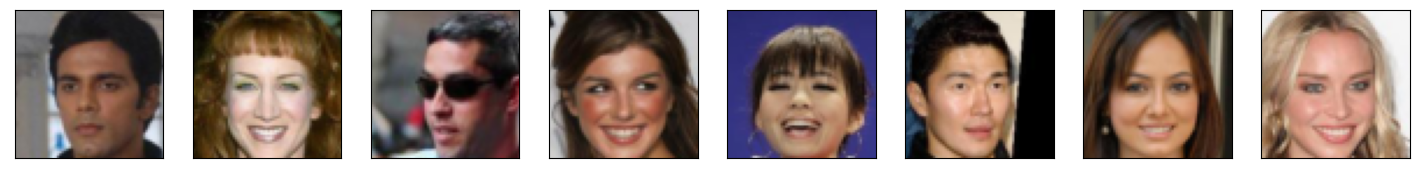

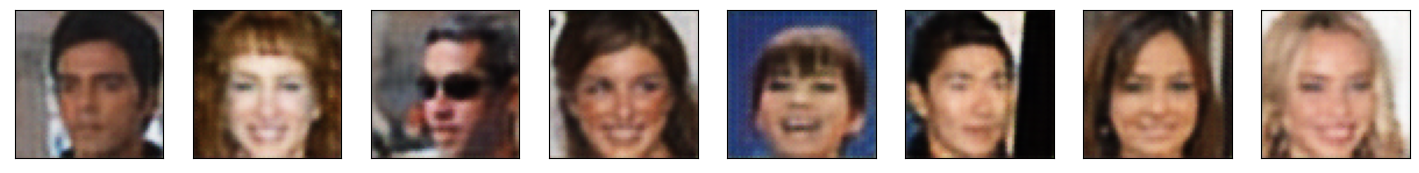

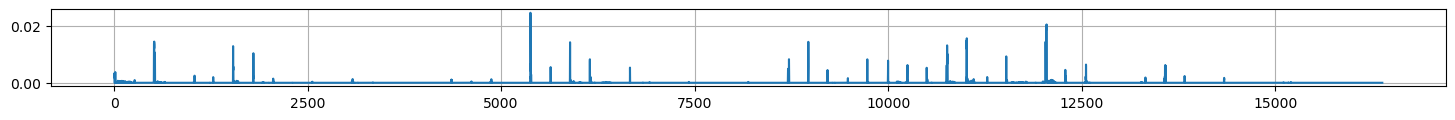

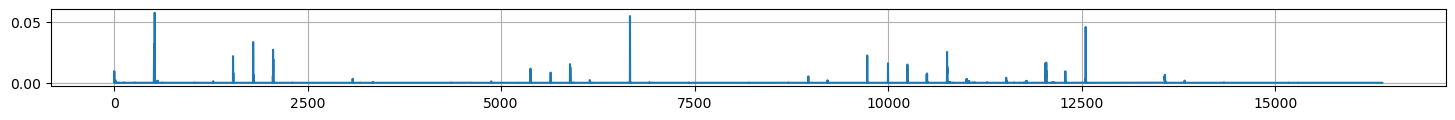

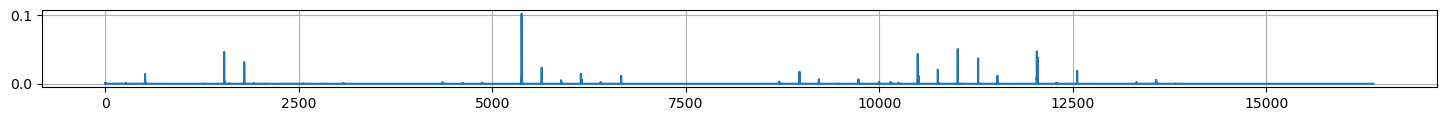

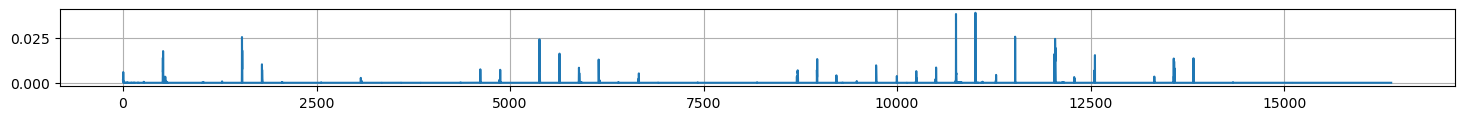

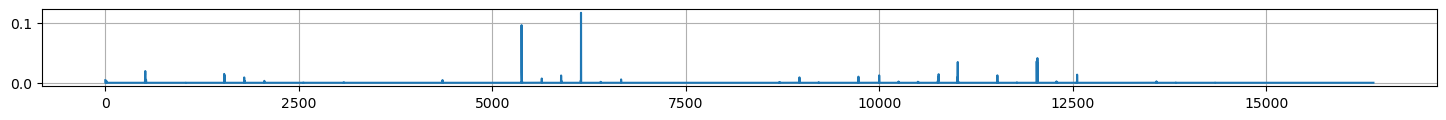

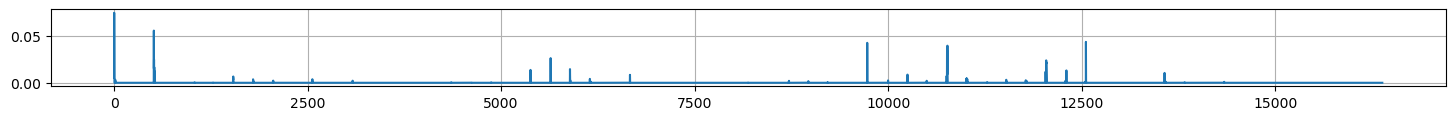

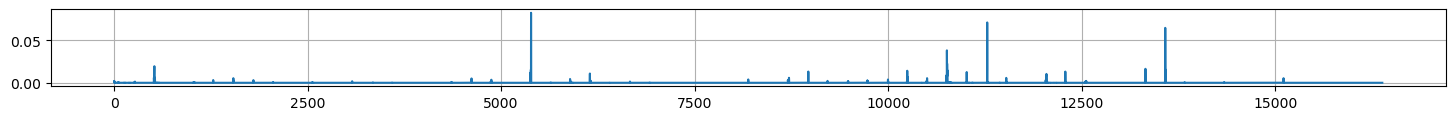

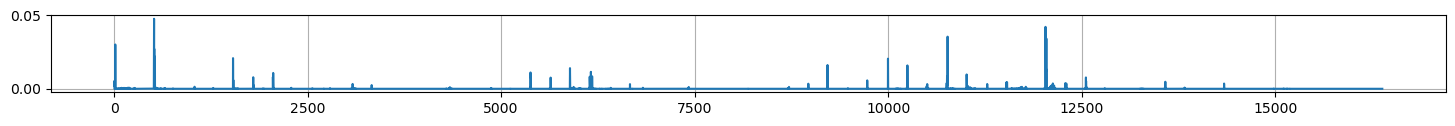

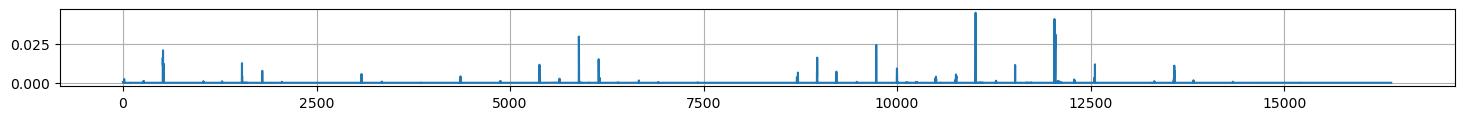

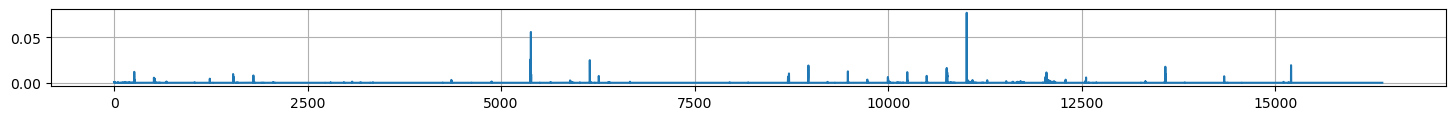

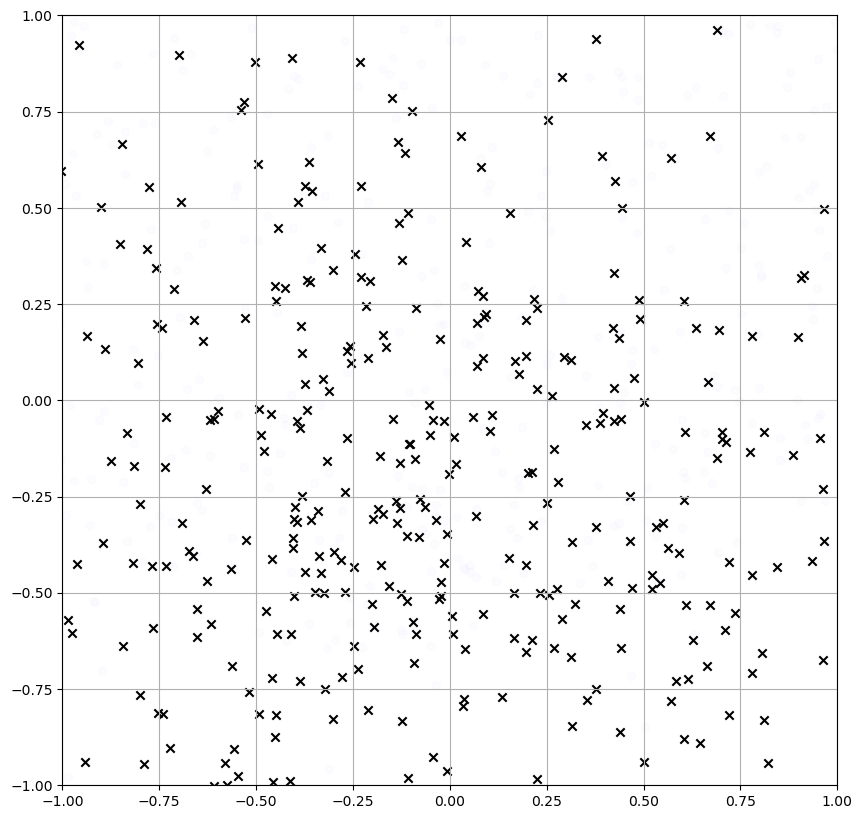

2001
lse_loss -26.997459411621094
commit_loss 0.14832058548927307
recon_loss 0.0024928105995059013
2002
lse_loss -27.078144073486328
commit_loss 0.15519273281097412
recon_loss 0.0023099337704479694
2003
lse_loss -27.066665649414062
commit_loss 0.152944415807724
recon_loss 0.0022584060207009315
2004
lse_loss -27.059589385986328
commit_loss 0.15776070952415466
recon_loss 0.002664354396983981
2005
lse_loss -27.173274993896484
commit_loss 0.1567559838294983
recon_loss 0.0026920288801193237
2006
lse_loss -26.909374237060547
commit_loss 0.15551510453224182
recon_loss 0.002503565978258848
2007
lse_loss -27.024585723876953
commit_loss 0.15783843398094177
recon_loss 0.002831513062119484
2008
lse_loss -27.244117736816406
commit_loss 0.15460848808288574
recon_loss 0.0023931674659252167
2009
lse_loss -27.157955169677734
commit_loss 0.15362364053726196
recon_loss 0.002463194075971842
2010
lse_loss -27.351009368896484
commit_loss 0.15490864217281342
recon_loss 0.0022897126618772745
2011
lse_loss -26

lse_loss -27.463787078857422
commit_loss 0.1524689942598343
recon_loss 0.002134470036253333
2087
lse_loss -27.565521240234375
commit_loss 0.14859718084335327
recon_loss 0.002281015273183584
2088
lse_loss -27.36904525756836
commit_loss 0.15086324512958527
recon_loss 0.0025365599431097507
2089
lse_loss -27.31081771850586
commit_loss 0.1537686288356781
recon_loss 0.0020592822693288326
2090
lse_loss -27.52558135986328
commit_loss 0.14668536186218262
recon_loss 0.002197067951783538
2091
lse_loss -27.289630889892578
commit_loss 0.15362705290317535
recon_loss 0.002515119034796953
2092
lse_loss -27.31853485107422
commit_loss 0.1507556438446045
recon_loss 0.0026478373911231756
2093
lse_loss -27.703262329101562
commit_loss 0.14763031899929047
recon_loss 0.002292650518938899
2094
lse_loss -27.180057525634766
commit_loss 0.15691959857940674
recon_loss 0.0024573304690420628
2095
lse_loss -27.55276107788086
commit_loss 0.1510373055934906
recon_loss 0.0024222740903496742
2096
lse_loss -27.71134185791

lse_loss -28.204261779785156
commit_loss 0.14663323760032654
recon_loss 0.0026089453604072332
2172
lse_loss -27.737689971923828
commit_loss 0.14865636825561523
recon_loss 0.0021458170376718044
2173
lse_loss -27.84148406982422
commit_loss 0.1449221968650818
recon_loss 0.0022433095145970583
2174
lse_loss -27.432403564453125
commit_loss 0.14715313911437988
recon_loss 0.0021407976746559143
2175
lse_loss -27.970760345458984
commit_loss 0.14620913565158844
recon_loss 0.002281591296195984
2176
lse_loss -27.749797821044922
commit_loss 0.14705371856689453
recon_loss 0.0024477243423461914
2177
lse_loss -27.929454803466797
commit_loss 0.14535142481327057
recon_loss 0.0024506235495209694
2178
lse_loss -28.079448699951172
commit_loss 0.1433665156364441
recon_loss 0.002221038332208991
2179
lse_loss -27.976211547851562
commit_loss 0.1472637802362442
recon_loss 0.0024428279139101505
2180
lse_loss -27.537277221679688
commit_loss 0.15002094209194183
recon_loss 0.0021903240121901035
2181
lse_loss -27.836

lse_loss -28.28940200805664
commit_loss 0.14547115564346313
recon_loss 0.00225629354827106
2257
lse_loss -28.12765884399414
commit_loss 0.14753660559654236
recon_loss 0.0022835449781268835
2258
lse_loss -28.44696044921875
commit_loss 0.1483016014099121
recon_loss 0.0021119951270520687
2259
lse_loss -28.018463134765625
commit_loss 0.14965911209583282
recon_loss 0.002217301167547703
2260
lse_loss -28.12860107421875
commit_loss 0.15302294492721558
recon_loss 0.0029754750430583954
2261
lse_loss -28.289199829101562
commit_loss 0.14804594218730927
recon_loss 0.0024301474913954735
2262
lse_loss -28.46350860595703
commit_loss 0.14498531818389893
recon_loss 0.002346442546695471
2263
lse_loss -28.435291290283203
commit_loss 0.14848393201828003
recon_loss 0.0024050576612353325
2264
lse_loss -28.396427154541016
commit_loss 0.14666271209716797
recon_loss 0.0020174612291157246
2265
lse_loss -28.281505584716797
commit_loss 0.14886394143104553
recon_loss 0.002326037734746933
2266
lse_loss -28.23624801

2341
lse_loss -28.641712188720703
commit_loss 0.13183942437171936
recon_loss 0.0020785126835107803
2342
lse_loss -28.698604583740234
commit_loss 0.14017239212989807
recon_loss 0.002324684988707304
2343
lse_loss -28.730998992919922
commit_loss 0.1378573775291443
recon_loss 0.0023575606755912304
2344
lse_loss -28.432064056396484
commit_loss 0.14573073387145996
recon_loss 0.00208001839928329
2345
lse_loss -28.820331573486328
commit_loss 0.13761119544506073
recon_loss 0.0019404925405979156
2346
lse_loss -28.651737213134766
commit_loss 0.1440328061580658
recon_loss 0.002405571285635233
2347
lse_loss -28.709697723388672
commit_loss 0.13984879851341248
recon_loss 0.0021224848460406065
2348
lse_loss -28.415416717529297
commit_loss 0.14264345169067383
recon_loss 0.00210402300581336
2349
lse_loss -28.485145568847656
commit_loss 0.13982392847537994
recon_loss 0.002157749142497778
2350
lse_loss -28.694828033447266
commit_loss 0.14330363273620605
recon_loss 0.002426933031529188
2351
lse_loss -28.37

2426
lse_loss -29.169208526611328
commit_loss 0.13893093168735504
recon_loss 0.002857363549992442
2427
lse_loss -28.867137908935547
commit_loss 0.13471731543540955
recon_loss 0.0020034369081258774
2428
lse_loss -28.900760650634766
commit_loss 0.14135992527008057
recon_loss 0.0024560943711549044
2429
lse_loss -28.9417724609375
commit_loss 0.14444854855537415
recon_loss 0.0022836499847471714
2430
lse_loss -28.982852935791016
commit_loss 0.13855251669883728
recon_loss 0.0023547618184238672
2431
lse_loss -28.84921646118164
commit_loss 0.13691258430480957
recon_loss 0.002067861845716834
2432
lse_loss -29.208900451660156
commit_loss 0.13551519811153412
recon_loss 0.002232130616903305
2433
lse_loss -28.97378921508789
commit_loss 0.14012548327445984
recon_loss 0.0020325733348727226
2434
lse_loss -28.78554916381836
commit_loss 0.14227356016635895
recon_loss 0.001990760676562786
2435
lse_loss -28.890033721923828
commit_loss 0.13211064040660858
recon_loss 0.0020535029470920563
2436
lse_loss -28.7

2511
lse_loss -29.107105255126953
commit_loss 0.13046276569366455
recon_loss 0.0020572158973664045
2512
lse_loss -29.47357177734375
commit_loss 0.13644734025001526
recon_loss 0.0018869740888476372
2513
lse_loss -29.453113555908203
commit_loss 0.13673195242881775
recon_loss 0.0021063564345240593
2514
lse_loss -29.388538360595703
commit_loss 0.1382087767124176
recon_loss 0.0020233369432389736
2515
lse_loss -29.372753143310547
commit_loss 0.13228186964988708
recon_loss 0.0023277862928807735
2516
lse_loss -29.083728790283203
commit_loss 0.1360510289669037
recon_loss 0.001961757196113467
2517
lse_loss -29.356098175048828
commit_loss 0.13300296664237976
recon_loss 0.002026529982686043
2518
lse_loss -29.186092376708984
commit_loss 0.13731437921524048
recon_loss 0.0020642904564738274
2519
lse_loss -29.264816284179688
commit_loss 0.13278327882289886
recon_loss 0.0020098970271646976
2520
lse_loss -29.458084106445312
commit_loss 0.13582801818847656
recon_loss 0.0025979718193411827
2521
lse_loss -

2596
lse_loss -29.992382049560547
commit_loss 0.12734735012054443
recon_loss 0.0018533937400206923
2597
lse_loss -29.76366424560547
commit_loss 0.1303521990776062
recon_loss 0.0021933300886303186
2598
lse_loss -29.826953887939453
commit_loss 0.13154788315296173
recon_loss 0.002165607176721096
2599
lse_loss -29.834636688232422
commit_loss 0.1357652246952057
recon_loss 0.0025659361854195595
2600
lse_loss -29.719379425048828
commit_loss 0.1359107345342636
recon_loss 0.0023007174022495747
2601
lse_loss -29.812911987304688
commit_loss 0.13392135500907898
recon_loss 0.0020959735848009586
2602
lse_loss -29.61642837524414
commit_loss 0.13419955968856812
recon_loss 0.003006670158356428
2603
lse_loss -29.882190704345703
commit_loss 0.13103504478931427
recon_loss 0.0018575263675302267
2604
lse_loss -29.837894439697266
commit_loss 0.13308769464492798
recon_loss 0.002131518442183733
2605
lse_loss -29.69576644897461
commit_loss 0.1354670375585556
recon_loss 0.0020323435310274363
2606
lse_loss -29.75

2681
lse_loss -30.05841064453125
commit_loss 0.12958525121212006
recon_loss 0.001979884458705783
2682
lse_loss -29.896282196044922
commit_loss 0.12406296283006668
recon_loss 0.0018672582227736712
2683
lse_loss -30.19019317626953
commit_loss 0.12318441271781921
recon_loss 0.002099668839946389
2684
lse_loss -29.961071014404297
commit_loss 0.1274227350950241
recon_loss 0.002260517096146941
2685
lse_loss -30.240177154541016
commit_loss 0.12383872270584106
recon_loss 0.002382071688771248
2686
lse_loss -30.151065826416016
commit_loss 0.12200751155614853
recon_loss 0.0017837157938629389
2687
lse_loss -30.336463928222656
commit_loss 0.1299617886543274
recon_loss 0.002650399459525943
2688
lse_loss -30.063411712646484
commit_loss 0.13534808158874512
recon_loss 0.0021249607671052217
2689
lse_loss -30.203685760498047
commit_loss 0.12813684344291687
recon_loss 0.002233348786830902
2690
lse_loss -29.915477752685547
commit_loss 0.1331115961074829
recon_loss 0.0019518518820405006
2691
lse_loss -30.409

2766
lse_loss -30.29220962524414
commit_loss 0.12688353657722473
recon_loss 0.002577980514615774
2767
lse_loss -30.412303924560547
commit_loss 0.12480639666318893
recon_loss 0.002085269894450903
2768
lse_loss -30.184364318847656
commit_loss 0.1269669234752655
recon_loss 0.00218709628097713
2769
lse_loss -30.340930938720703
commit_loss 0.12425760179758072
recon_loss 0.0019753016531467438
2770
lse_loss -30.35708999633789
commit_loss 0.1308930367231369
recon_loss 0.0019359893631190062
2771
lse_loss -30.160411834716797
commit_loss 0.12575043737888336
recon_loss 0.0018748476868495345
2772
lse_loss -30.297149658203125
commit_loss 0.12663230299949646
recon_loss 0.001906073186546564
2773
lse_loss -30.42404556274414
commit_loss 0.1294528990983963
recon_loss 0.0019141047960147262
2774
lse_loss -30.427227020263672
commit_loss 0.1263246089220047
recon_loss 0.001881105243228376
2775
lse_loss -30.40389633178711
commit_loss 0.12608063220977783
recon_loss 0.0020629181526601315
2776
lse_loss -30.359508

lse_loss -30.52707290649414
commit_loss 0.12789253890514374
recon_loss 0.00191276497207582
2851
lse_loss -30.67337417602539
commit_loss 0.12333692610263824
recon_loss 0.0018954237457364798
2852
lse_loss -30.572097778320312
commit_loss 0.12803788483142853
recon_loss 0.0019216733053326607
2853
lse_loss -30.589534759521484
commit_loss 0.12335333228111267
recon_loss 0.0018065755721181631
2854
lse_loss -30.735431671142578
commit_loss 0.12090416252613068
recon_loss 0.001970045967027545
2855
lse_loss -30.800662994384766
commit_loss 0.1241988018155098
recon_loss 0.0019603667315095663
2856
lse_loss -30.596210479736328
commit_loss 0.12567974627017975
recon_loss 0.0018826806917786598
2857
lse_loss -30.691299438476562
commit_loss 0.12209469079971313
recon_loss 0.0019426185172051191
2858
lse_loss -30.571277618408203
commit_loss 0.1243845596909523
recon_loss 0.0027749459259212017
2859
lse_loss -30.68082046508789
commit_loss 0.12706808745861053
recon_loss 0.002367666456848383
2860
lse_loss -30.638324

lse_loss -30.948684692382812
commit_loss 0.13035690784454346
recon_loss 0.0019912677817046642
2936
lse_loss -30.653194427490234
commit_loss 0.12591156363487244
recon_loss 0.0019747780170291662
2937
lse_loss -30.94180679321289
commit_loss 0.12804897129535675
recon_loss 0.0020277441944926977
2938
lse_loss -31.157894134521484
commit_loss 0.12035293132066727
recon_loss 0.0016711474163457751
2939
lse_loss -31.102367401123047
commit_loss 0.12036735564470291
recon_loss 0.0017860973021015525
2940
lse_loss -30.486133575439453
commit_loss 0.1268334686756134
recon_loss 0.00261880224570632
2941
lse_loss -30.929828643798828
commit_loss 0.12008130550384521
recon_loss 0.0022099455818533897
2942
lse_loss -30.724197387695312
commit_loss 0.12248145788908005
recon_loss 0.0017110195476561785
2943
lse_loss -31.070980072021484
commit_loss 0.12737268209457397
recon_loss 0.002573210746049881
2944
lse_loss -30.945331573486328
commit_loss 0.12416858971118927
recon_loss 0.0021245121024549007
2945
lse_loss -31.15

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-5
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.grid()
plt.show() 